# MobileNetV2 Based Classifier

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
import seaborn as sns

from src.__00__paths import docs_dir, model_dir, figures_dir, data_dir

## Load & Preprocess Data

In [6]:
data, labels = [], []
mobileNet_data_size = (224, 224)  # MobileNet expects this input shape


def load_preprocessed_data(df_title):
    csv_path = data_dir / df_title
    data_df = pd.read_csv(csv_path)
    data, labels = [], []
    for _, row in data_df.iterrows():
        image_path = data_dir / row["Path"]
        try:
            image = Image.open(image_path).convert("RGB")
            image = image.resize(mobileNet_data_size)
            data.append(np.array(image))
            labels.append(row["ClassId"])
        except:
            pass
    return np.array(data), np.array(labels)


train_data, train_labels = load_preprocessed_data("Train.csv")
x_test, y_test = load_preprocessed_data("Test.csv")
y_test_labels = y_test

## Train Validation Split

In [10]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=43)

x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

## Build MobileNetV2 Model

In [11]:
classes = 43
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=mobileNet_data_size + (3,)))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/var/folders/nd/j_4pfhk1777112pmlz3plg_m0000gn/T/ipykernel_34560/2164677845.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=mobileNet_data_size + (3,)))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train Model

In [12]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=64)
model.save(model_dir / "mobilenet_traffic_classifier.h5")

Epoch 1/15


2025-08-01 16:02:57.340041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


491/491 ━━━━━━━━━━━━━━━━━━━━ 165s 324ms/step - accuracy: 0.1876 - loss: 3.6822 - val_accuracy: 0.5159 - val_loss: 1.5746
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 150s 305ms/step - accuracy: 0.4254 - loss: 1.9827 - val_accuracy: 0.5963 - val_loss: 1.2637
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 151s 307ms/step - accuracy: 0.5236 - loss: 1.4890 - val_accuracy: 0.6144 - val_loss: 1.1542
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 155s 315ms/step - accuracy: 0.5739 - loss: 1.3041 - val_accuracy: 0.6482 - val_loss: 1.0610
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 162s 331ms/step - accuracy: 0.6177 - loss: 1.1646 - val_accuracy: 0.6574 - val_loss: 1.0084
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 154s 314ms/step - accuracy: 0.6300 - loss: 1.1157 - val_accuracy: 0.6913 - val_loss: 0.9327
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 153s 312ms/step - accuracy: 0.6520 - loss: 1.0404 - val_accuracy: 0.6880 - val_loss: 0.9144
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 290s 591ms/step - accuracy: 0.6656 - loss: 1.00

## Predict Output

In [14]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 49s 124ms/step


## Evaluate Model

Test Accuracy: 58.97%

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.56      0.54      0.55       720
           2       0.31      0.52      0.38       750
           3       0.44      0.28      0.34       450
           4       0.54      0.55      0.54       660
           5       0.63      0.28      0.39       629
           6       0.89      0.54      0.67       150
           7       0.49      0.60      0.54       450
           8       0.54      0.55      0.55       450
           9       0.59      0.71      0.65       480
          10       0.86      0.83      0.84       660
          11       0.52      0.44      0.48       420
          12       0.93      0.92      0.93       690
          13       0.98      0.87      0.92       720
          14       0.95      0.93      0.94       270
          15       0.80      0.96      0.87       210
          16       0.67      0.80 

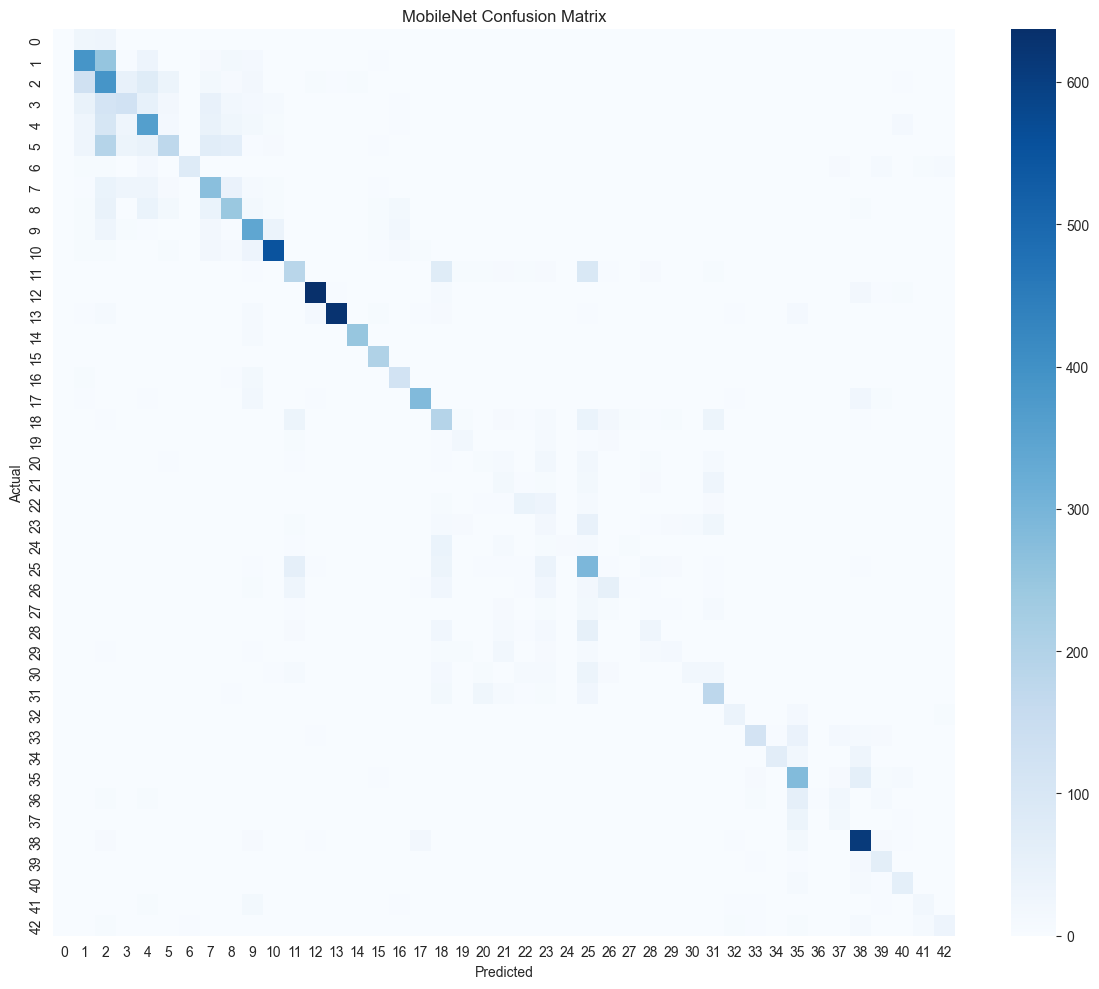

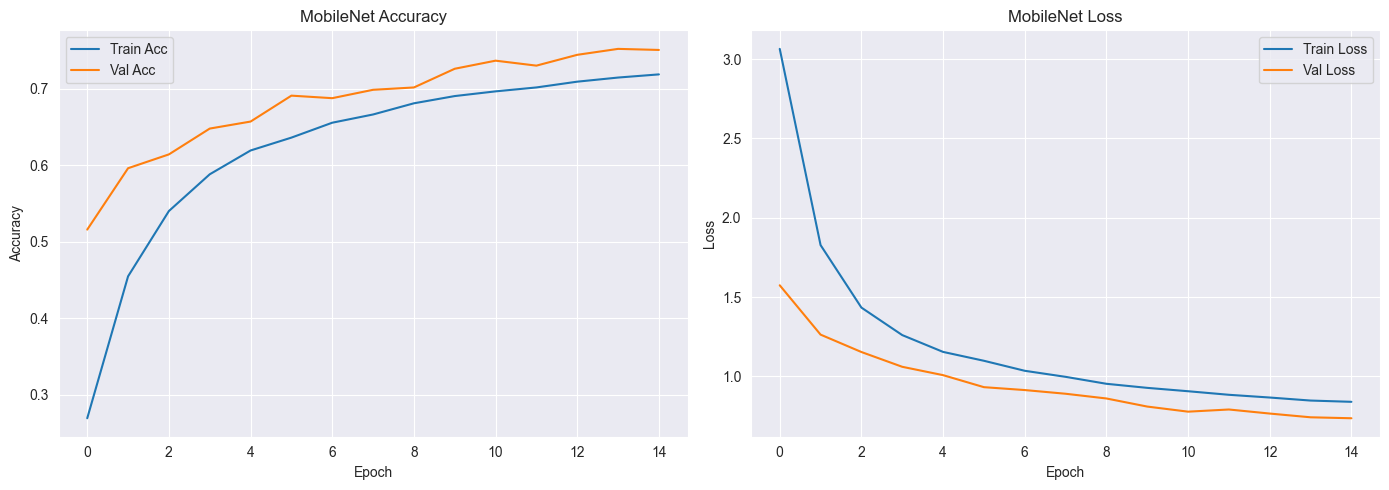

In [17]:
acc = accuracy_score(y_test_labels, y_pred) * 100
report = classification_report(y_test_labels, y_pred, zero_division=0)
cm = confusion_matrix(y_test_labels, y_pred)

# 2. Print evaluation summary
print(f"Test Accuracy: {acc:.2f}%")
print("\nClassification Report:\n")
print(report)

# 3. Save classification report
with open(docs_dir / "mobilenet_classification_report.txt", "w") as f:
    f.write(f"Test Accuracy: {acc:.2f}%\n\n")
    f.write(report)

# 4. Plot and save confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", fmt="d")
plt.title("MobileNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(figures_dir / "mobilenet_confusion_matrix.png", dpi=300)
plt.show()

# 5. Plot and save training performance
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('MobileNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MobileNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(figures_dir / "mobilenet_training_performance.png", dpi=300)
plt.show()